# Estimation of the Hurst index of a fractional Brownian field via a CNN.

## Author: Frédéric Richard, 2022

# 1. Data preparation.

The data can be download from the Kaggle site [PyAFBF textures - set 001](https://www.kaggle.com/datasets/frdricrichard/pyafbf-textures-set-001). The whole dataset is in the archive file **full-database.tgz**.

## 1.1. Define a custom batch generator.

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amet6c","key":"ca7e3b79d7e339b605af5377a616aba8"}'}

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: all-images/image-015003.png  
  inflating: all-images/image-015004.png  
  inflating: all-images/image-015005.png  
  inflating: all-images/image-015006.png  
  inflating: all-images/image-015007.png  
  inflating: all-images/image-015008.png  
  inflating: all-images/image-015009.png  
  inflating: all-images/image-015010.png  
  inflating: all-images/image-015011.png  
  inflating: all-images/image-015012.png  
  inflating: all-images/image-015013.png  
  inflating: all-images/image-015014.png  
  inflating: all-images/image-015015.png  
  inflating: all-images/image-015016.png  
  inflating: all-images/image-015017.png  
  inflating: all-images/image-015018.png  
  inflating: all-images/image-015019.png  
  inflating: all-images/image-015020.png  
  inflating: all-images/image-015021.png  
  inflating: all-images/image-015022.png  
  inflating: all-images/image-015023.png  
  inflating: all-im

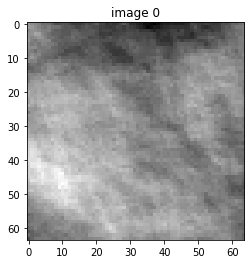

(64, 64)

In [ ]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
# List available datasets.
!kaggle datasets list
!kaggle datasets download -d frdricrichard/pyafbf-textures-set-002
!unzip pyafbf-textures-set-002.zip
from numpy import loadtxt
features = loadtxt( "features.csv", delimiter=",")
example_index = 0
print("Features of the example " + str(example_index))
print(features[example_index, :])


from imageio import imread
from matplotlib import pyplot as plt

def ImagePath(index_example):
    """Set the path to a given example."""
    image_id = str(1000000 + index_example)[1:]
    return( "all-images/image-" + image_id + ".png")

image_path = ImagePath(example_index)

image = imread(image_path)
ax = plt.imshow(image, cmap="gray")
plt.title("image " + str(example_index))
plt.show()
image.shape

In [ ]:
import sys
from tensorflow.keras.utils import Sequence
from imageio import imread
from numpy import zeros, floor_divide, loadtxt


def ImagePath(index_example, input_dir):
    """Define the path to an image.

    Parameters:
    -----------
    index_example: int
        index of the image
    input_dir: str
        path to the data directory.

    Returns: str
        path to the image
    """

    image_id = str(1000000 + index_example)[1:]
    return(input_dir + "image-" + image_id + ".png")


def ExportData(data_dir, n_start, n_end, f, norm):
    """Export the data.

    Parameters:
    -----------

    data_dir: str
        path to the data directory
    n_start: int
        first example.
    n_end: int
        last example.
    f: int
        feature index.
    norm: boolean
        True if images are to be normalized.

    Returns:
        images: ndarray
            batch of images; images is an array of size N x N x
            (n_end - n_start + 1):
            images[j, :, :] is the image of the (n_start + j)th example.
        features: ndarray of size N x N x (n_end - n_start + 1):
            features[j, :] are the features of the (n_start +j)th examples.

          * features[j, 0] is the Hurst index.
          * features[j, 1] is the length of the Hurst argmin set.
          * features[j, 2] is the center of the Hurst argmin set.
          * features[j, 3] is the range length of the Hurst function.
            features;
    """
    nbexamples = n_end - n_start + 1
    images = zeros((nbexamples, 64, 64, 1), dtype=float)
    for j in range(n_start, n_end + 1):
        j0 = j - n_start
        image_path = ImagePath(j, data_dir)
        image = imread(image_path)
        if norm:
            image = (image - mean(image)) / std(image)
        images[j0, :, :, 0] = image[:, :]

    features = loadtxt(data_dir + "features.csv", delimiter=",")
    return(images, features[n_start:n_end+1, f])


class Custom_Generator(Sequence):
    def __init__(self, data_dir, n0, n1, batch_size, f0, norm=False):
        """
        Parameters
        ----------
        batch_size : int
            Size of the batches.
        n0 : int
            First example of the set.
        n1 : int
            Last example of the set.
        f0 : int
            Index of the feature to be estimated.
        """
        self.data_dir = data_dir
        self.n0 = n0
        self.n1 = n1
        self.batch_size = batch_size
        self.f0 = f0
        self.norm = norm

    def __len__(self):
        """Number of batches for each epoch.

        Returns
        -------
        np.int
            Number of batch for each epoch.
        """
        return floor_divide(self.n1 - self.n0 + 1, self.batch_size)

    def __getitem__(self, idx):
        # Batch construction.
        n_start = self.n0 + idx * self.batch_size
        n_end = n_start + self.batch_size - 1
        batch, feature = ExportData(self.data_dir, n_start, n_end, self.f0, self.norm)
        feature = reshape(feature, (self.batch_size, 1, 1, 1))
        return batch, feature

    def batch_memory_size(self):
        """Compute the memory size in Giga bytes of a batch.
        """
        return sys.getsizeof(zeros((self.batch_size, 64, 64, 1))) * 10e-9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Set the training, validation and test datasets.

In [ ]:
# Data parameters
# Data directory
data_dir = "all-images/"
# Number of examples used for learning the DNN.
N00 = 0
N01 = 17999
# Number of examples used for validation while learning the DNN.
N10 = 18000
N11 = 18999
# Number of examples used for testing data.
N20 = 19000
N21 = 19999
# Feature to be estimated.
f0 = 1
norm = False  # True if images are to be normalized.
# Batch size.
batch_size = 20

training_set = Custom_Generator(data_dir, N00, N01, batch_size, f0, norm)
validation_set = Custom_Generator(data_dir, N10, N11, batch_size, f0, norm)
test_set = Custom_Generator(data_dir, N20, N21, batch_size, f0, norm)

# 2. Set the neural network architecture.

## 2.1. Define a CNN neural network.

In [ ]:

import tensorflow as tf
from tensorflow.keras import backend as K
from numpy import zeros, reshape, mean, std


# Filter kernel initialization.
def IdentityFilters(shape, dtype=None):
    filters = zeros(shape)
    filters[0, 0, :, :] = 1

    return filters


# Filter kernel initialization.
def IncrementFilters(shape, dtype=None):
    filters = zeros(shape)
    filters[0, 0, 0, :] = 1
    filters[0, 1, 0, 0] = -2
    filters[1, 0, 0, 1] = -2
    filters[0, 2, 0, 0] = 1
    filters[2, 0, 0, 1] = 1

    return filters


# Layer: square activation.
class Square_Activation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Square_Activation, self).__init__(**kwargs)

    def call(self, inputs):
        return K.square(inputs)


# Layer: Square maximum activation.
class SquareMax_Activation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SquareMax_Activation, self).__init__(**kwargs)

    def call(self, inputs):
        return K.maximum(K.square(inputs), 1)


# Layer: Log activation.
class Log_Activation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Log_Activation, self).__init__(**kwargs)

    def call(self, inputs):
        return K.log(inputs)


# Layer: Square activation and average pooling.
class Mean_Square_Pooling(tf.keras.layers.Layer):
    def __init__(self, activation="square", **kwargs):
        super(Mean_Square_Pooling, self).__init__(**kwargs)
        if activation == "square":
            self.activation = Square_Activation()
        else:
            self.activation = SquareMax_Activation()

    def call(self, inputs):
        return K.mean(self.activation(inputs), axis=[1, 2], keepdims=True)


# Layer: Transpoe.
class Transpose(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Transpose, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.transpose(inputs, perm=[0, 2, 1, 3])


# Layer: Concatenate.
class Concatenate(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Concatenate, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.concat(inputs, axis=3)


# Layer: Convolutional Pyramid.
class Conv_Pyramid(tf.keras.layers.Layer):
    def __init__(
        self,
        nlayers=5,
        skip_connection=False,
        train=True,
        activation="square",
        **kwargs
    ):
        """Define a series of pyramidal convolution layers.

        Parameters
        ----------
        nlayers : int, optional
            Number of layers. The default is 5.
        skip_connection : boolean, optional
            Option for skipping connections. The default is False.
        activation : str, optional
            The activation after convolutions. The default is 'square'.
        train : boolean, optional
            Option for training layers. The default is True.
        **kwargs : (see Layer.__init__)
        """
        super(Conv_Pyramid, self).__init__(**kwargs)
        self.nlayers = nlayers
        self.train = train
        self.nf = 2
        self.scale = 1
        self.skip_connection = skip_connection

        if skip_connection:
            M = nlayers + 1
        else:
            M = 1

        self.MSP = []
        for m in range(M):
            self.MSP.append(Mean_Square_Pooling(activation,
                                                name="msp_" + str(m)))
        # self.Perm = tf.keras.layers.Permute(dims=(2, 1))

    def build(self, input_shape):

        self.w = []
        nf = 1
        for j in range(self.nlayers):
            nf0 = nf
            nf = nf * 2
            # Set weights for nf kernels of size 3x3 to be applied
            # on nf0 inputs.
            if j == 0:
                self.w.append(
                    self.add_weight(
                        name="conv_" + str(j),
                        shape=(3, 3, nf0, nf),
                        initializer=IncrementFilters,
                        trainable=self.train,
                    )
                )
            else:
                self.w.append(
                    self.add_weight(
                        name="conv_" + str(j),
                        shape=(3, 3, nf0, nf),
                        # initializer=IdentityFilters,
                        trainable=self.train,
                    )
                )

    def call(self, inputs):
        y = inputs
        m = 0
        if self.skip_connection:
            z = self.MSP[0](y)
            m += 1

        scale = 1
        for j in range(self.nlayers):
            # Convolution of the jth layer at scale.
            y = K.conv2d(
                y,
                self.w[j],
                strides=(1, 1),
                padding="valid",
                data_format="channels_last",
                dilation_rate=(1, 1),  # scale, scale),
            )
            scale = scale * 2

            if self.skip_connection:
                z = tf.concat(values=[z, self.MSP[m](y)], axis=3)
                m += 1

        if not self.skip_connection:
            # Mean square pooling.
            z = self.MSP[m](y)

        return z


class CNNModel(tf.keras.Model):
    def __init__(self,
                 nlayers_conv=5,
                 skip_connection=False,
                 sym=False,
                 activation_conv="square",
                 train_conv=True,
                 nlayers_dense=0,
                 activation_dense="relu",
                 units_dense=10,
                 activation_last=None,
                 **kwargs):
        super(CNNModel, self).__init__(**kwargs)
        self.sym = sym
        self.cp = Conv_Pyramid(
            nlayers_conv,
            skip_connection,
            train_conv,
            activation_conv,
            name=str(nlayers_conv) + "_layers")

        self.log = Log_Activation(name="log")
        self.nlayers_dense = nlayers_dense
        self.dense = []
        for j in range(nlayers_dense):
            self.dense.append(
                tf.keras.layers.Dense(
                    units_dense, activation=activation_dense,
                    name="dense_" + str(j),
                )
            )
        self.dense_final = tf.keras.layers.Dense(
            1, activation=activation_last, name="last_layer"
        )
        if self.sym:
            self.transpose = Transpose(name="transpose")
            self.concat = Concatenate(name="concatenation")

    def call(self, inputs):
        y = inputs
        if self.sym:
            yt = self.transpose(y)

        y = self.cp(y)
        y = self.log(y)

        if self.sym:
            yt = self.cp(yt)
            yt = self.log(yt)
            y = self.concat([y, yt])

        for j in range(self.nlayers_dense):
            y = self.dense[j](y)
        y = self.dense_final(y)

        return y

## 2.2. Specify the model.

In [ ]:
from tensorflow.random import normal

# CNN Parameters
# Convolutional layers (bottom of the CNN)
# Number of pyramidal convolutional layers.
nlayers_conv = 4
skc = True
# Symmetrization
sym = True

# Dense layers (top of the CNN)
# Number of dense layers.
nlayers_dense = 4
# Ativation for dense layers.
activation_dense = "relu"
# Number of units by dense layer.
units_dense = 20

# Set the neural network model.
model = CNNModel(nlayers_conv=nlayers_conv, skip_connection=skc, sym=sym,
                 nlayers_dense=nlayers_dense,
                 activation_dense=activation_dense,
                 units_dense=units_dense,
                 activation_last=None)
z = model(normal([1, 64, 64, 1]))
model.summary()

Model: "cnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 4_layers (Conv_Pyramid)     multiple                  1530      
                                                                 
 log (Log_Activation)        multiple                  0         
                                                                 
 dense_0 (Dense)             multiple                  1260      
                                                                 
 dense_1 (Dense)             multiple                  420       
                                                                 
 dense_2 (Dense)             multiple                  420       
                                                                 
 dense_3 (Dense)             multiple                  420       
                                                                 
 last_layer (Dense)          multiple                  

# 3. Learn the model.

## 3.1. Prepare for optimization.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TerminateOnNaN
from tensorflow.keras.metrics import RootMeanSquaredError as rmse

output_file = "/home/frichard/Recherche/PyAFBF/PyAFBF-cnn/learned_models/cnn"

# Optimization parameters
# Number of epochs used for learning the DNN.
n_epochs = 5
# Optimizer
optimizer = "Adam"
# Loss function.
loss = "MSE"


# Set optimization parameters.
model.compile(loss=loss, optimizer=optimizer, metrics=[rmse()])

# Call back : for saving the model.
checkpoint = ModelCheckpoint(
    filepath=output_file,
    save_weights_only=True,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

# To stop iterations in the case of divergence.
term_nan = TerminateOnNaN()

# 3.2. Fit the model.

In [ ]:
# Optimization.
history = model.fit(
    x=training_set,
    steps_per_epoch=len(training_set),
    epochs=n_epochs,
    verbose=1,
    callbacks=[checkpoint, term_nan],
    validation_data=validation_set,
    workers=1,
    use_multiprocessing=False,
)

Epoch 1/5
900/900 [==============================] - ETA: 0s - loss: 2.3279 - root_mean_squared_error: 1.5257
Epoch 1: val_loss improved from inf to 0.76451, saving model to /home/frichard/Recherche/PyAFBF/PyAFBF-cnn/learned_models/cnn
900/900 [==============================] - 317s 350ms/step - loss: 2.3279 - root_mean_squared_error: 1.5257 - val_loss: 0.7645 - val_root_mean_squared_error: 0.8744
Epoch 2/5
900/900 [==============================] - ETA: 0s - loss: 0.8010 - root_mean_squared_error: 0.8950
Epoch 2: val_loss improved from 0.76451 to 0.76388, saving model to /home/frichard/Recherche/PyAFBF/PyAFBF-cnn/learned_models/cnn
900/900 [==============================] - 309s 343ms/step - loss: 0.8010 - root_mean_squared_error: 0.8950 - val_loss: 0.7639 - val_root_mean_squared_error: 0.8740
Epoch 3/5
900/900 [==============================] - ETA: 0s - loss: 0.7973 - root_mean_squared_error: 0.8929
Epoch 3: val_loss did not improve from 0.76388
900/900 [============================

# 4. Test the model.

In [ ]:
model.evaluate(test_set)

50/50 [==============================] - 11s 210ms/step - loss: 7.2822e-04 - root_mean_squared_error: 0.0270


[0.0007282201549969614, 0.02698555402457714]